# 300_RQ3

## Purpose
In this notebook we will be doing the basic analysis of our second RQ:

- "Does past experience of a founder effect the amount of funding received by a startup?"



## Datasets
* _Input_: 300_analysis_RQ2.pkl
* _Output_: None

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_columns', None)
module_path = os.path.abspath(os.path.join('../../data/..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline

In [2]:
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_palette("muted")
sns.set_context("poster")

# Text, lines, and markers...
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['lines.markersize'] = 15
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 22

## Importing dataset 2

This is the same dataset we used for our analysis of RQ2. It contains information about each founder like their education and also details about the startup they founded. As mentioned in previous notebooks, the reason there are multiple person instances in our dataset is because: 
- A duplicate person instance if they have founded multiple companies.
- A duplicate person instance if they have changed positions in the same company.
- A duplicate person instance if they have attain another degree/change institution while at the same company.

However, we do not see the need of merging these rows together as they would store too much information. Not only this, having the rows seperated makes it easier for our analysis of this RQ when looking at the Highest Degree and Institutions attended by the founders.

In [3]:
founders_df_raw = pd.read_pickle('../../data/analysis/300_analysis_RQ2.pkl')
founders_df_raw.shape

(44711, 55)

In [4]:
founders_df_raw.head(5)

,first_name,last_name,gender,company_name,funding_rounds,funding_total_usd,primary_role,country_code,state_code,city,title,job_type,subject,degree_type,person_uuid,degree_uuid,institution_uuid,org_uuid,Highest_Degree,Administrative Services,Advertising,Agriculture and Farming,Biotechnology,Clothing and Apparel,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Content and Publishing,Design,Education,Energy,Events,Food and Beverage,Government and Military,Hardware,Health Care,Manufacturing,Media and Entertainment,Music and Audio,Natural Resources,Navigation and Mapping,Platforms,Privacy and Security,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Sports,Sustainability,Transportation,Travel and Tourism,Video,Technology,Finance,Communication
0,Steve,Wozniak,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Co-founder,executive,EE & CS,bs,f3abe539-8db3-57e4-0f4d-de54a78eaf68,fe3eb345-b465-84ad-45d7-448f8f7a44e5,Berkeley,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Kevin,Harvey,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Engineering,bs,e7f5c146-66c5-fba4-64cb-8ffd422899d8,0dee09e8-13b6-50ee-3e17-1343036b2eed,c3144da5-8618-2e95-3a13-60417220da5e,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Armas,Markkula,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Electrical Engineering,bs,56e8a800-5c37-7599-5eb3-b815aa6acd30,29b2a7bc-4628-0e5d-53d1-d0af77d3de33,867f0af5-a1d0-143d-bbed-5cc252ca40d6,7063d087-96b8-2cc1-ee88-c221288acc2a,Masters,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Armas,Markkula,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Electrical Engineering,ms,56e8a800-5c37-7599-5eb3-b815aa6acd30,9da52706-0933-81f3-5be3-5ae30747612e,867f0af5-a1d0-143d-bbed-5cc252ca40d6,7063d087-96b8-2cc1-ee88-c221288acc2a,Masters,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Kristee,Rosendahl,female,Apple,4,6.150250e+09,company,USA,CA,Cupertino,"Designer, Art Director, Human Interface Co-fou...",employee,Design,ba,035e9cc5-d2a4-9298-7488-c348527a5d1a,0c2be7d4-47cd-8758-e668-34593c6c605f,Stanford,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Defining an experienced founder

The first point of action for this RQ is defining what an experienced founder is. We have decided that it is someone who has founded more than one startup. Therefore, a founder is defined as inexperienced if they have only found one startup. 

**Grouping founders...**

In [5]:
# grouping raw founders dataframe by person_uuid and org_uuid. Aggergating total funding for grouped organisation
founders_df = founders_df_raw.groupby(['person_uuid','org_uuid'],as_index=False).agg({'funding_total_usd':'first', 'company_name':'first'})
founders_df.head(5)

,person_uuid,org_uuid,funding_total_usd,company_name
0,00026df9-9254-269d-40b1-549e9529550d,d2d0cb83-b874-c5d7-c7f7-fb77613cc95b,1016992.0,Ethos
1,000497ac-d3f9-7969-6c8b-b4050c8efc04,14658850-0cc9-15f8-62f3-a8c532ea6c61,8521954.0,Tomorrow Ideas
2,000575b8-eac0-66b1-2a16-03c08c2b9f66,d2de0c01-397d-b4f1-8575-9b5e74e6b6b8,30000.0,Emerging Star Investment Group
3,0005da7e-2311-9002-7756-ed2f2734e057,2aec3826-0f75-1f21-326a-5dbca9d5ff15,7387100.0,Upptalk
4,0005da7e-2311-9002-7756-ed2f2734e057,bd4c4326-ef34-d5d9-b689-0c0b0a6ba03c,3428769.0,Housers


## Average funding attained by Experienced and Non-Experienced Founders
Next we will investigate the average funding of experienced founders vs non-experienced founders

**Calculating the mean funding of experienced founders...**

In [6]:
# this experienced bool condition allows us to only group founders who have a group size > 1 when used as a df mask
experienced = founders_df.groupby('person_uuid',sort=False)["person_uuid"].transform(len) > 1

In [7]:
founders_df[~experienced].shape

(24203, 4)

In [8]:
founders_df[experienced].funding_total_usd.mean()

61334476.27111414

**Saving mean value into variable and dividing it to get value in terms of millions...**

In [9]:
val1 = founders_df[experienced].funding_total_usd.mean()
val1 = val1/1000000 # division to get in terms of millions
val1

61.33447627111414

**Calculating the mean funding of non-experienced founders...**

In [10]:
founders_df[~experienced].funding_total_usd.mean()

34031255.31355617

**Saving mean value into variable and dividing it to get value in terms of millions...**

In [11]:
val2 = founders_df[~experienced].funding_total_usd.mean()
val2 = val2/1000000 # division to get in terms of millions
val2

34.03125531355617

**Plotting these values results in...**

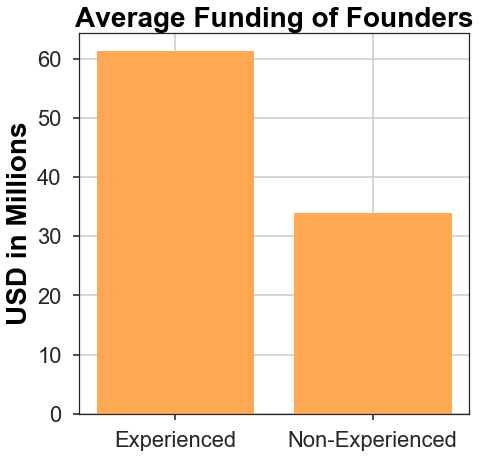

In [12]:
x = np.arange(2)
means = [val1,val2]
plt.figure(figsize=(7,7))
plt.bar(x, means, color='#ffa954')
plt.xticks(x, ('Experienced','Non-Experienced'))
plt.title("Average Funding of Founders")
plt.ylabel("USD in Millions")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Experienced founders funding percentage change

In this section we will look at the percentage change in funding of experienced founders. There is no need to filter non-experienced founders in this analysis from the original founders dataframe. 

In [13]:
# grouping by unique person identifier and finding percentage change of funding.
founders_df['pct'] = founders_df.groupby('person_uuid').funding_total_usd.pct_change()
founders_df.head(10)

,person_uuid,org_uuid,funding_total_usd,company_name,pct
0,00026df9-9254-269d-40b1-549e9529550d,d2d0cb83-b874-c5d7-c7f7-fb77613cc95b,1016992.0,Ethos,NaN
1,000497ac-d3f9-7969-6c8b-b4050c8efc04,14658850-0cc9-15f8-62f3-a8c532ea6c61,8521954.0,Tomorrow Ideas,NaN
2,000575b8-eac0-66b1-2a16-03c08c2b9f66,d2de0c01-397d-b4f1-8575-9b5e74e6b6b8,30000.0,Emerging Star Investment Group,NaN
3,0005da7e-2311-9002-7756-ed2f2734e057,2aec3826-0f75-1f21-326a-5dbca9d5ff15,7387100.0,Upptalk,NaN
4,0005da7e-2311-9002-7756-ed2f2734e057,bd4c4326-ef34-d5d9-b689-0c0b0a6ba03c,3428769.0,Housers,-0.535844
5,00065f25-101a-bfe2-d79c-a172af342c70,6663f9d3-e6ab-348f-66c7-cafc00ce01a8,50000.0,Weightup Solutions,NaN
6,00065f25-101a-bfe2-d79c-a172af342c70,a1102c6c-1bc4-b6aa-c5f2-6c34bd4b2370,18100000.0,Fetch Rewards,361.000000
7,000792fb-3022-cac3-eea5-a93a49150727,7b224a36-b7b4-d02f-bf76-b4ac9ba085ca,11920000.0,Mux,NaN
8,00082be1-4c28-c41f-6147-92d0e12629c8,000ad7a8-b868-f301-5f00-2a3361288fc9,25200000.0,Eligible,NaN
9,00086acf-adf2-b9cc-e600-442bfba4412d,fcf35538-c297-85aa-4fd8-230d4a64125a,20000.0,Vite Car Services LLP,NaN


**Next Step...**

Using the 'pct' field we previously transformed, we will find the mean percentage change of funding for an experienced founder.

In [14]:
founders_df[~founders_df.pct.isnull()]['pct'].mean()

32.02943378324194

## CONCLUSION

This research question did not work out for us as hoped initally. 

We have deemed it inconclusive. 

The fact that some founders startups do not have a funding value when we first received the data was not ideal. This limited us in terms of looking at previous founding experience. Some founders had multiple startups that were not included as they had no funding value.

We have identified that looking at other job aspects of instead of purely founding experience would allow for a larger sample size. This is something we will suggest as future work for this topic/area.